# notebook for data description and merging 
# *Panopea* transcriptome

In [1]:
from Bio import SeqIO, AlignIO
from Bio import SeqIO, SwissProt
from Bio.SeqUtils import GC, GC_skew
from Bio.SeqRecord import SeqRecord

from pandas import Series, DataFrame
import pandas as pd

import pylab
import matplotlib.pyplot as plt 

import numpy as np
from numpy import *

In [2]:
def cpg(secuencia):
    g= secuencia.count("G")
    c= secuencia.count("C")
    cg= secuencia.count("CG")
    lar= len(secuencia)
    cpG=0
    try:
        g*c==0
    except:
        cpG=0
    else:
        if g == 0 or c== 0:
            cpG =0
        else:
            cpG=(round(cg/(g*c)*(lar**2/(lar-1)) ,8))
    return (cpG)

In [3]:
def columnas(file):
    m, m1 = 0,1
    for rowm in file:
        print ( "%2i %-16s" % (m1,rowm), end="\t")
        m+=1
        m1+=1
        if m==4:
            print("")
            m=0
    print()

In [4]:
f = open('../panopea_data/data-results/Geoduck-transcriptome-v3.fa', 'r')

In [5]:
sizes = [(rec.name, len(rec), round(GC(rec.seq),4), cpg(rec.seq)) for rec in SeqIO.parse(f, "fasta")]
#f.close()
sizesdataf= DataFrame(sizes,columns= ["ContigID", "length", "GC", "CpG"] )
sizesdataf.head()

,ContigID,length,GC,CpG
0,comp100000_c0_seq1,453,33.9956,0.919033
1,comp100001_c1_seq1,493,30.4260,0.264219
2,comp100001_c2_seq1,558,30.6452,0.233631
3,comp100002_c0_seq1,208,40.8654,0.985872
4,comp100004_c1_seq1,276,31.5217,0.439224


In [6]:
sizesdataf.describe()

,length,GC,CpG
count,153982.000000,153982.000000,153982.000000
mean,660.440233,36.034563,0.547723
std,765.421464,6.727696,0.323846
min,201.000000,13.043500,0.000000
25%,253.000000,31.065650,0.323447
50%,372.000000,34.905700,0.492127
75%,734.000000,40.390000,0.727148
max,18024.000000,84.386600,3.514344


It should give these results

|	|length|GC content	|CpG|
|---|------|--|---------|---|
|count	|153982.000000	|153982.000000	|153982.000000|
|mean	|660.440233	|36.034563	|0.547723|
|std	|765.421464	|6.727696	|0.323846|
|min	|201.000000	|13.043500	|0.000000|
|25%	|253.000000	|31.065650	|0.323447|
|50%	|372.000000	|34.905700	|0.492127|
|75%	|734.000000	|40.390000	|0.727148|
|max	|18024.000000	|84.386600	|3.514344|

In [7]:
%matplotlib inline

#### sequences description from notebook
*01-Geoduck-fasta-v3.ipynb*

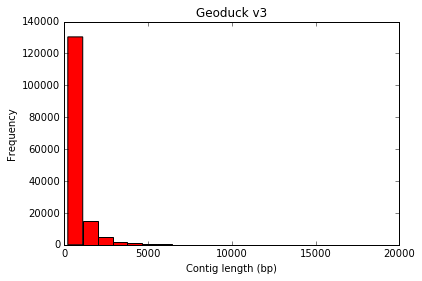

In [8]:
ax= plt.gca()
ax.hist(sizesdataf['length'], bins=20, color = 'r')
ax.set_xlabel('Contig length (bp)')
ax.set_ylabel('Frequency')
ax.set_title (r"Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3length.png")
plt.show()

### log10 transformation

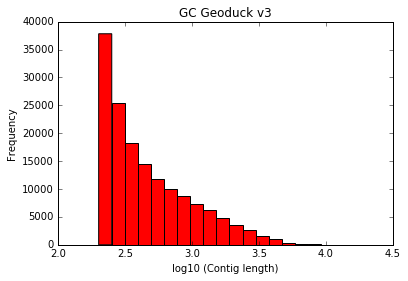

In [9]:
ax= plt.gca()
ax.hist(np.log10(sizesdataf['length']), bins=20, color = 'r')
ax.set_xlabel('log10 (Contig length)')
ax.set_ylabel('Frequency')
ax.set_title (r"GC Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3loglength.png")
plt.show()

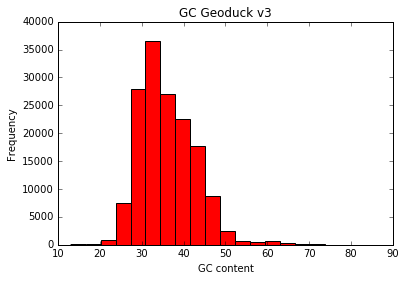

In [10]:
ax= plt.gca()
ax.hist(sizesdataf['GC'], bins=20, color = 'r')
ax.set_xlabel('GC content')
ax.set_ylabel('Frequency')
ax.set_title (r"GC Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3gc.png")
plt.show()

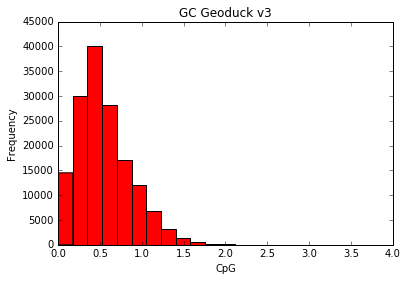

In [11]:
ax= plt.gca()
ax.hist(sizesdataf['CpG'], bins=20, color = 'r')
ax.set_xlabel('CpG')
ax.set_ylabel('Frequency')
ax.set_title (r"GC Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3gc.png")
plt.show()

# Adding Blast results

In [12]:
encabezado =("ContigID", "sseqid1", "sseqid2", "sseqid3", "pident", "Length", "mismatch", "gapopen", "qstart", 
             "qend", "sstart","send", "Evalue", "bitscore",)
f_blastx = pd.read_csv ("../panopea_data/data-results/Geoduck-tranv3-blastx_sprot.sorted", delimiter=" ", 
                        index_col=None, names= encabezado, header= None)
f_blastx.sort_values(by ="ContigID")
f_blastx.head(2)

,ContigID,sseqid1,sseqid2,sseqid3,pident,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore
0,comp100065_c0_seq1,sp,Q5PRC1,LHFP_DANRE,48.00,50,26,0,151,2,100,149,2.000000e-08,51.6
1,comp100097_c0_seq1,sp,Q9UI26,IPO11_HUMAN,41.05,229,130,3,2,679,699,925,2.000000e-37,144.0


In [13]:
columnas(f_blastx)

 1 ContigID        	 2 sseqid1         	 3 sseqid2         	 4 sseqid3         	
 5 pident          	 6 Length          	 7 mismatch        	 8 gapopen         	
 9 qstart          	10 qend            	11 sstart          	12 send            	
13 Evalue          	14 bitscore        	


### finding whether the sequence is in the complimentary strand and saving it in the "strand" column

In [14]:
secuencias = []
n=0 
linea = ''
for row in f_blastx.index:
    rows= f_blastx.ix[row]
    if rows["qend"]-rows["qstart"]<0:
        linea=rows["ContigID"],-1
    else:
        linea= rows["ContigID"],1
    secuencias.append( linea)
    n+=1

secuencias = pd.DataFrame(secuencias, columns=['ContigID', 'strand'])
secuencias.head()

,ContigID,strand
0,comp100065_c0_seq1,-1
1,comp100097_c0_seq1,1
2,comp100104_c2_seq1,1
3,comp100105_c1_seq1,-1
4,comp100108_c1_seq1,1


In [15]:
f_blastx = pd.merge(f_blastx, secuencias, on= "ContigID")
f_blastx.head()

,ContigID,sseqid1,sseqid2,sseqid3,pident,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100065_c0_seq1,sp,Q5PRC1,LHFP_DANRE,48.00,50,26,0,151,2,100,149,2.000000e-08,51.6,-1
1,comp100097_c0_seq1,sp,Q9UI26,IPO11_HUMAN,41.05,229,130,3,2,679,699,925,2.000000e-37,144.0,1
2,comp100104_c2_seq1,sp,Q9NZJ4,SACS_HUMAN,47.83,138,58,4,2,397,2586,2715,3.000000e-29,118.0,1
3,comp100105_c1_seq1,sp,P18756,ETS1B_XENLA,85.71,126,18,0,402,25,143,268,2.000000e-73,233.0,-1
4,comp100108_c1_seq1,sp,Q9U943,APLP_LOCMI,32.45,413,227,9,4,1104,514,920,3.000000e-59,214.0,1


### Adding GO-ID, GO description and Protein names

In [16]:
f_annotation = pd.read_csv ("../panopea_data/data-results/Geoduck_v3_uniprot_wGO.csv", index_col=None)
f_annotation.sort_values(by ="ContigID")
f_annotation.head(2)

,ContigID,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names
0,comp100065_c0_seq1,2.000000e-08,Q5PRC1,GO:0016021,integral to membrane,Lipoma HMGIC fusion partner homolog
1,comp100097_c0_seq1,2.000000e-37,Q9UI26,GO:0005737; GO:0005634; GO:0008565; GO:0006610,cytoplasm; nucleus; protein transporter activi...,Importin-11 (Imp11) (Ran-binding protein 11) (...


In [17]:
#checking data
len(sizesdataf), len(f_blastx), len(f_annotation)

(153982, 22974, 22974)

In [18]:
f1= pd.merge(f_annotation, f_blastx, on= "ContigID", how="inner")
f1.head(2)

,ContigID,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,sseqid2,sseqid3,pident,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100065_c0_seq1,2.000000e-08,Q5PRC1,GO:0016021,integral to membrane,Lipoma HMGIC fusion partner homolog,sp,Q5PRC1,LHFP_DANRE,48.00,50,26,0,151,2,100,149,2.000000e-08,51.6,-1
1,comp100097_c0_seq1,2.000000e-37,Q9UI26,GO:0005737; GO:0005634; GO:0008565; GO:0006610,cytoplasm; nucleus; protein transporter activi...,Importin-11 (Imp11) (Ran-binding protein 11) (...,sp,Q9UI26,IPO11_HUMAN,41.05,229,130,3,2,679,699,925,2.000000e-37,144.0,1


In [19]:
len(f1),len(sizesdataf), len(f_annotation), len(f_blastx)

(22974, 153982, 22974, 22974)

In [20]:
columnas (sizesdataf)
print()
columnas (f1)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	


 1 ContigID        	 2 evalue          	 3 UniProt_Acc     	 4 Gene ontology IDs	
 5 Gene ontology (GO)	 6 Protein names   	 7 sseqid1         	 8 sseqid2         	
 9 sseqid3         	10 pident          	11 Length          	12 mismatch        	
13 gapopen         	14 qstart          	15 qend            	16 sstart          	
17 send            	18 Evalue          	19 bitscore        	20 strand          	



In [21]:
f2= pd.merge(sizesdataf, f1, on= "ContigID", how="outer")
f2.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
len(f2),len(sizesdataf), len(f_annotation), len(f_blastx)

(153982, 153982, 22974, 22974)

In [23]:
columnas (sizesdataf)
print()
columnas (f2)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	


 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	


### Adding expression data

In [24]:
f_exp = pd.read_csv ("../panopea_data/data-results/Male-v-Female-Expression.csv", index_col=None)
f_exp.head()

,FeatureID,range,difference,fold_change,male_unique,male_total,female_unique,female_total
0,comp144588_c2_seq1,20506477,-20506477,-3.426534,28957409,28957409,8450932,8450932
1,comp144588_c3_seq1,19963924,-19963924,-3.796427,27102977,27103006,7139078,7139082
2,comp144588_c4_seq1,15492666,-15492666,-3.083767,22927597,22927597,7434931,7434931
3,comp144588_c1_seq1,822446,-822446,-3.120936,1210217,1210221,387774,387775
4,comp128741_c0_seq1,338448,-338448,-25.461405,352284,352284,13836,13836


In [25]:
len(f_exp)

154407

### the file Male-v-Female-Expression.csv
seems to have the data from all contigs including the non-eukaryote

In [26]:
f_exp = f_exp.rename(columns={"FeatureID" : 'ContigID'})
del f_exp['male_total']
del f_exp['range']
del f_exp['difference']
del f_exp['female_total']
f_exp.head()

,ContigID,fold_change,male_unique,female_unique
0,comp144588_c2_seq1,-3.426534,28957409,8450932
1,comp144588_c3_seq1,-3.796427,27102977,7139078
2,comp144588_c4_seq1,-3.083767,22927597,7434931
3,comp144588_c1_seq1,-3.120936,1210217,387774
4,comp128741_c0_seq1,-25.461405,352284,13836


In [27]:
f3 = pd.merge(f2, f_exp, on= "ContigID", how='inner')
f3.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,qstart,qend,sstart,send,Evalue,bitscore,strand,fold_change,male_unique,female_unique
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.571429,7,11
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.500000,2,49
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.714286,7,82
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,6
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7,0


In [28]:
columnas (f2)
print()
columnas (f_exp)
print()
columnas (f3)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	

 1 ContigID        	 2 fold_change     	 3 male_unique     	 4 female_unique   	


 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        

In [29]:
len(f3)

153982

In [30]:
len(f2), len(f3)

(153982, 153982)

# Calculating the expression and male and female features

In [31]:
mafa=[]
linea=''
n=200
for rows in f3.index:
    row= f3.ix[rows]
    linea=''
    if row["fold_change"]>100 and row['female_unique']>200 and row['male_unique']!=0:
        linea= row['ContigID'],"female>male" 
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'female>male')
    elif row["fold_change"]<-100 and row['male_unique']>200 and row['female_unique']!=0:
        linea= row['ContigID'],"male>female" 
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'male>female')
    elif row["fold_change"]>100 and row['female_unique']>200 and row['male_unique']==0:
        linea= row['ContigID'],"female" 
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'female')
    elif row["fold_change"]<-100 and row['male_unique']>200 and row['female_unique']==0:
        linea= row['ContigID'],"male"
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'male')
    else:
        linea= row['ContigID'],""
    mafa.append(linea)

mafa= pd.DataFrame(mafa, columns=['ContigID', 'sex'])
mafa.describe()        
mafa.groupby('sex')['ContigID'].count()

sex
               153430
female             42
female>male       339
male               35
male>female       136
Name: ContigID, dtype: int64

In [32]:
f4 = pd.merge(f3, mafa, on= "ContigID")
f4.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,qend,sstart,send,Evalue,bitscore,strand,fold_change,male_unique,female_unique,sex
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.571429,7,11,
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.500000,2,49,
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.714286,7,82,
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,6,
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7,0,


In [33]:
del f4['fold_change']
f4.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,qstart,qend,sstart,send,Evalue,bitscore,strand,male_unique,female_unique,sex
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,11,
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,49,
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,82,
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,


In [34]:
f4.groupby('sex')['ContigID'].count()

sex
               153430
female             42
female>male       339
male               35
male>female       136
Name: ContigID, dtype: int64

In [35]:
columnas (f3)
print()
columnas (f4)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	24 fold_change     	
25 male_unique     	26 female_unique   	

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	2

#### these are the only female, male or differential expression data

## adding Gigaton, *Ruphi* and Dh data

In [36]:
f_exp = pd.read_table ("../panopea_data/data-results/Master-SP-Gig-Ruphi_Dh.txt", index_col=None, engine='python')
f_exp.head()

,Pgen-ID,evalue-SP,SPID,ProteinName,Organism,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp123774_c0_seq1,0.000000e+00,P06603,Tubulin alpha-1 chain,Drosophila melanogaster (Fruit fly),antimicrobial humoral response [GO:0019730]; m...,PF00091;PF03953;,0.000000e+00,CHOYP_RABGAP1.1.1,0.000000e+00,ruditapes2_c97,0.000000e+00,AJ431728.p.cg.6,6.0,male gonad
1,comp140491_c1_seq2,1.000000e-119,Q25410,Putative molluscan insulin-related peptide(s) ...,Lymnaea stagnalis (Great pond snail) (Helix st...,transmembrane receptor protein tyrosine kinase...,PF00041;PF00757;PF07714;PF01030;,2.000000e-104,CHOYP_MIPR.1.2,NaN,NaN,1.000000e-101,AJ535669.p.cg.6,2.0,NaN
2,comp142230_c1_seq2,9.000000e-131,Q8MPM1,Gelsolin-like protein 2 (Actin-modulator) (EWA...,Lumbricus terrestris (Common earthworm),actin filament capping [GO:0051693],PF00626;,2.000000e-79,CHOYP_LOC100371249.1.1,NaN,NaN,7.000000e-74,AJ563467.p.cg.6,4.0,NaN
3,comp144511_c0_seq9,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,CHOYP_ANLN.1.1,NaN,NaN,2.000000e-116,AM237648.p.cg.6,7.0,NaN
4,comp139165_c0_seq2,0.000000e+00,P07201,Ribonucleoside-diphosphate reductase small cha...,Spisula solidissima (Atlantic surf-clam),deoxyribonucleoside diphosphate metabolic proc...,PF00268;,0.000000e+00,CHOYP_RIR2.1.1,4.000000e-86,ruditapes_c11036,5.000000e-83,AM237649.p.cg.6,9.0,NaN


In [37]:
f_exp = f_exp.rename(columns={"Pgen-ID" : 'ContigID'})
f_exp.head()

,ContigID,evalue-SP,SPID,ProteinName,Organism,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp123774_c0_seq1,0.000000e+00,P06603,Tubulin alpha-1 chain,Drosophila melanogaster (Fruit fly),antimicrobial humoral response [GO:0019730]; m...,PF00091;PF03953;,0.000000e+00,CHOYP_RABGAP1.1.1,0.000000e+00,ruditapes2_c97,0.000000e+00,AJ431728.p.cg.6,6.0,male gonad
1,comp140491_c1_seq2,1.000000e-119,Q25410,Putative molluscan insulin-related peptide(s) ...,Lymnaea stagnalis (Great pond snail) (Helix st...,transmembrane receptor protein tyrosine kinase...,PF00041;PF00757;PF07714;PF01030;,2.000000e-104,CHOYP_MIPR.1.2,NaN,NaN,1.000000e-101,AJ535669.p.cg.6,2.0,NaN
2,comp142230_c1_seq2,9.000000e-131,Q8MPM1,Gelsolin-like protein 2 (Actin-modulator) (EWA...,Lumbricus terrestris (Common earthworm),actin filament capping [GO:0051693],PF00626;,2.000000e-79,CHOYP_LOC100371249.1.1,NaN,NaN,7.000000e-74,AJ563467.p.cg.6,4.0,NaN
3,comp144511_c0_seq9,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,CHOYP_ANLN.1.1,NaN,NaN,2.000000e-116,AM237648.p.cg.6,7.0,NaN
4,comp139165_c0_seq2,0.000000e+00,P07201,Ribonucleoside-diphosphate reductase small cha...,Spisula solidissima (Atlantic surf-clam),deoxyribonucleoside diphosphate metabolic proc...,PF00268;,0.000000e+00,CHOYP_RIR2.1.1,4.000000e-86,ruditapes_c11036,5.000000e-83,AM237649.p.cg.6,9.0,NaN


In [38]:
f5 = pd.merge(f4, f_exp)
f5.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
columnas (f4)
print()
columnas (f_exp)
print()
columnas (f5)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	24 male_unique     	
25 female_unique   	26 sex             	

 1 ContigID        	 2 evalue-SP       	 3 SPID            	 4 ProteinName     	
 5 Organism        	 6 GO              	 7 PFAM            	 8 evalue-GIG      	
 9 Gigaton-ID      	10 evalue-Ru       	11 Ruphibase_ID    	12 evalue-SIG      	
13 SigID           	14 Cluster         	15 Tissue-enriched-expression	

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene onto

## saving big table

In [ ]:
f5.to_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_bigtablefinal.csv",index=None)

### setting "ContigID" column as index

In [40]:
f5.set_index(["ContigID"])

,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,sseqid2,...,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
ContigID,,,,,,,,,,,,,,,,,,,,,
comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100007_c0_seq1,734,32.1526,0.689395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100010_c0_seq1,246,38.2114,1.136696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100011_c0_seq1,315,33.6508,0.562483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100012_c0_seq1,218,35.3211,0.152087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## copying annotation "Protein names" to the fasta file

In [41]:
f = open('../panopea_data/data-results/Geoduck-transcriptome-v3.fa', 'r')
secuencias=[]
linea=''
n=1
for rec in SeqIO.parse(f, "fasta"):
    descripcion = str(f5.loc[f5["ContigID"]==rec.id]['Protein names'].values[0])
    if f5.loc[f5["ContigID"]==rec.id]['strand'].values[0]<1:
        secuencia=rec.seq.reverse_complement()
    else:
        secuencia=rec.seq
    if descripcion != "nan" :
        linea =SeqRecord(secuencia, id=rec.id, description="PREDICTED "+descripcion[:]+
                         " [Panopea generosa]")
    else :
        linea =SeqRecord(secuencia, id=rec.id, description=rec.id)#rec.description)
    secuencias.append(linea)
    if n%1000==0 and n<10000:
        print ("processing sequence ",n, "please wait")
        #break
    elif n%10000==0:
        print ("processing sequence ",n, "please wait")
    n+=1
print ("processing finished a total of  ",n, " sequences")

processing sequence  1000 please wait
processing sequence  2000 please wait
processing sequence  3000 please wait
processing sequence  4000 please wait
processing sequence  5000 please wait
processing sequence  6000 please wait
processing sequence  7000 please wait
processing sequence  8000 please wait
processing sequence  9000 please wait
processing sequence  10000 please wait
processing sequence  20000 please wait
processing sequence  30000 please wait
processing sequence  40000 please wait
processing sequence  50000 please wait
processing sequence  60000 please wait
processing sequence  70000 please wait
processing sequence  80000 please wait
processing sequence  90000 please wait
processing sequence  100000 please wait
processing sequence  110000 please wait
processing sequence  120000 please wait
processing sequence  130000 please wait
processing sequence  140000 please wait
processing sequence  150000 please wait
processing finished a total of   153983  sequences


In [42]:
SeqIO.write(secuencias, '../panopea_data/data-results/Geoduck-transcriptome-v3annotatedfinal.fa', 'fasta')

153982

In [43]:
f5.to_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_bigtable_final.csv",index=None)

In [48]:
f5.describe(percentiles=None, include=None, exclude=None)

/Users/migueldelrio/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,length,GC,CpG,evalue,pident,Length,mismatch,gapopen,qstart,qend,...,Evalue,bitscore,strand,male_unique,female_unique,evalue-SP,evalue-GIG,evalue-Ru,evalue-SIG,Cluster
count,153982.000000,153982.000000,153982.000000,2.297400e+04,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,...,2.297400e+04,22974.000000,22974.000000,1.539820e+05,1.539820e+05,2.297400e+04,1.182300e+04,2.859000e+03,1.610000e+02,161.000000
mean,660.440233,36.034563,0.547723,1.579074e-07,47.638308,237.846522,113.254766,3.518282,615.388483,691.618090,...,1.579074e-07,207.460769,0.102202,6.234099e+02,4.694546e+02,1.579074e-07,1.298213e-12,2.300055e-12,5.716943e-63,6.074534
std,765.421464,6.727696,0.323846,8.874588e-07,15.308643,235.045473,113.382360,4.726599,955.302522,861.290176,...,8.874588e-07,251.066608,0.994785,1.168102e+05,3.526058e+04,8.874588e-07,8.160183e-12,1.043598e-11,6.327873e-62,2.344016
min,201.000000,13.043500,0.000000,0.000000e+00,17.250000,19.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000e+00,43.100000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,253.000000,31.065650,0.323447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
50%,372.000000,34.905700,0.492127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.000000e+00,1.200000e+01,NaN,NaN,NaN,NaN,NaN
75%,734.000000,40.390000,0.727148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.600000e+01,4.200000e+01,NaN,NaN,NaN,NaN,NaN
max,18024.000000,84.386600,3.514344,1.000000e-05,100.000000,4651.000000,2215.000000,106.000000,14380.000000,15034.000000,...,1.000000e-05,7080.000000,1.000000,2.895741e+07,8.450932e+06,1.000000e-05,1.000000e-10,1.000000e-10,8.000000e-61,10.000000


## checking the number of sequences matched with Dh data

In [49]:
f5.groupby('Tissue-enriched-expression')['ContigID'].count()

Tissue-enriched-expression
adductor muscle     1
female gonad        9
male gonad         12
Name: ContigID, dtype: int64

## checking the number of sequences matched with Gigaton data

In [50]:
gigaton= f5.groupby('Gigaton-ID')['ContigID'].count()
len(gigaton)

7683

In [51]:
gigaton= f5.groupby('Organism')['ContigID'].count()
len(gigaton)

981

#### there are too many data to represent in a graph

## Checking how many columns there are in the big table

In [52]:
columnas (f5)
print()

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	24 male_unique     	
25 female_unique   	26 sex             	27 evalue-SP       	28 SPID            	
29 ProteinName     	30 Organism        	31 GO              	32 PFAM            	
33 evalue-GIG      	34 Gigaton-ID      	35 evalue-Ru       	36 Ruphibase_ID    	
37 evalue-SIG      	38 SigID           	39 Cluster         	40 Tissue-enriched-expression	




In [ ]:
f5 = pd.read_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_bigtablefinal.csv", 
                  index_col=None, delimiter=",", engine='python' )
#f5.read_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_bigtablefinal.csv",index=None)
f5.head(2)


In [53]:
columnas (f5)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	24 male_unique     	
25 female_unique   	26 sex             	27 evalue-SP       	28 SPID            	
29 ProteinName     	30 Organism        	31 GO              	32 PFAM            	
33 evalue-GIG      	34 Gigaton-ID      	35 evalue-Ru       	36 Ruphibase_ID    	
37 evalue-SIG      	38 SigID           	39 Cluster         	40 Tissue-enriched-expression	



In [54]:
f5.head(2)

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Checking for similarities among columns

## "UniProt_Acc" and "sseqid2"

In [55]:
n=0 
linea = ''
for row in f5.index:
    rows= f5.ix[row]
    if str(rows["UniProt_Acc"])!=str(rows["sseqid2"]):
        print (n,rows["UniProt_Acc"],rows["sseqid2"])
        #continue
        n+=1
    #if n==100:
    #    break
print ("there are", n, "differences")

0 nan Q05654
1 nan Q05654
2 nan Q05654
3 nan Q05654
4 nan P10983
5 nan B6P4U0
6 nan B6P4U0
7 nan Q6ZU11
8 nan Q05654
9 nan Q9C0R2
10 nan Q05654
11 nan Q05654
12 nan Q9C0R2
there are 13 differences


## keep "sseqid2"

## "sseqid2" and "SPID"

In [56]:
n=0 
linea = ''
print (" ","SPID","sseqid2")
for row in f5.index:
    rows= f5.ix[row]
    if str(rows["SPID"])!=str(rows["sseqid2"]):
        print (n,rows["SPID"],rows["sseqid2"])
        #continue
        n+=1
    #if n==10:
    #    break
print ("there are", n, "differences")

  SPID sseqid2
0 nan P66844
1 nan Q05654
2 nan O05313
3 nan Q05654
4 nan P64803
5 nan Q05654
6 nan P66952
7 nan A8MQB9
8 nan P71667
9 nan Q05654
10 nan O42867
11 nan A0PJM3
12 nan O05916
13 nan O53454
14 nan Q9P324
15 nan Q6ZN80
16 nan P53625
17 nan P01744
18 nan O69669
19 nan P0A502
20 nan Q5TG08
21 nan Q6ZTY8
22 nan P63777
23 nan P33765
24 nan Q7D628
25 nan O05871
26 nan Q6ZTY8
27 nan P10983
28 nan Q9BZ01
29 nan O69669
30 nan Q6ZTY8
31 nan Q6ZTY8
32 nan Q6ZTY8
33 nan Q14591
34 nan Q14591
35 nan B6P4U0
36 nan B6P4U0
37 nan Q6ZTY8
38 nan Q6ZNL0
39 nan Q6ZTY8
40 nan Q6ZTY8
41 nan Q69YW0
42 nan Q69YW0
43 nan Q6ZTY8
44 nan Q6ZTY8
45 nan Q6ZTY8
46 nan Q6ZU11
47 nan Q5BKU6
48 nan P96920
49 nan O86350
50 nan P65336
51 nan O05586
52 nan Q05654
53 nan Q9C0R2
54 nan Q05654
55 nan O50465
56 nan Q10817
57 nan Q10817
58 nan A6NDJ8
59 nan P0A5Z4
60 nan Q05654
61 nan P0A522
62 nan P64314
63 nan P67202
64 nan P65336
65 nan Q10530
66 nan O53226
67 nan P65336
68 nan Q8N1W0
69 nan P0A4Z8
70 nan P0A620
7

## keep "sseqid2"

## "Protein names" and "ProteinName"

In [57]:
n, n1=0, 0

linea = ''
for row in f5.index:
    rows= f5.ix[row]
    if str(rows["Protein names"])!=str(rows["ProteinName"]):
        linea = str(rows["ProteinName"])[:20]
        if rows["Protein names"].find(linea)>-1:
            n+=1
            #print (n,str(rows["Protein names"])[:20],str(rows["ProteinName"])[:20], "found")
        else:
            n1+=1
            print (n1, rows["ContigID"]  , str(rows["Protein names"])[:20],str(rows["ProteinName"])[:20])
        #continue

    #if n==10:
    #    break
print ("there are", n, "similarities and", n1, "differences")

1 comp100298_c0_seq1 Histidine-specific m Histidine N-alpha-me
2 comp100892_c0_seq1 Protein MraZ Transcriptional regu
3 comp100892_c1_seq1 Protein MraZ Transcriptional regu
4 comp100934_c0_seq1 Fibrillin-1 Fibrillin-1 [Cleaved
5 comp100965_c0_seq1 ATP-dependent RNA he ATP-dependent DNA he
6 comp101197_c0_seq1 ADIPOR-like receptor Adiponectin receptor
7 comp101197_c1_seq1 ADIPOR-like receptor Adiponectin receptor
8 comp101491_c0_seq1 Signal recognition p nan
9 comp101610_c0_seq1 Putative DNA repair  DNA excision repair 
10 comp101610_c2_seq1 Putative DNA repair  DNA excision repair 
11 comp101656_c1_seq1 A/G-specific adenine Adenine DNA glycosyl
12 comp101903_c0_seq1 Type III iodothyroni Thyroxine 5-deiodina
13 comp101943_c0_seq1 Kunitz-type proteina KappaPI-actitoxin-Av
14 comp101943_c0_seq2 Protease inhibitor H Kunitz-type serine p
15 comp102546_c0_seq1 Transmembrane protei Nuclear envelope int
16 comp102644_c0_seq1 Lipid phosphate phos Phospholipid phospha
17 comp102705_c0_seq1 Capsu

## Keep both columns


In [58]:
columnas (f5)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	24 male_unique     	
25 female_unique   	26 sex             	27 evalue-SP       	28 SPID            	
29 ProteinName     	30 Organism        	31 GO              	32 PFAM            	
33 evalue-GIG      	34 Gigaton-ID      	35 evalue-Ru       	36 Ruphibase_ID    	
37 evalue-SIG      	38 SigID           	39 Cluster         	40 Tissue-enriched-expression	



In [59]:
del f5['sseqid1']
del f5["evalue"]
del f5["pident"]
del f5["Length"]
del f5["mismatch"]
del f5["gapopen"]
del f5["qstart"]
del f5["qend"]
del f5["sstart"]
del f5["send"]
del f5["bitscore"]
del f5["strand"]
del f5["evalue-SP"]
del f5["SPID"]
del f5["UniProt_Acc"]


In [60]:
columnas (f5)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 Gene ontology IDs	 6 Gene ontology (GO)	 7 Protein names   	 8 sseqid2         	
 9 sseqid3         	10 Evalue          	11 male_unique     	12 female_unique   	
13 sex             	14 ProteinName     	15 Organism        	16 GO              	
17 PFAM            	18 evalue-GIG      	19 Gigaton-ID      	20 evalue-Ru       	
21 Ruphibase_ID    	22 evalue-SIG      	23 SigID           	24 Cluster         	
25 Tissue-enriched-expression	


In [82]:
f5= f5.rename(columns={"sseqid2":"UniProt_Acc"})
f5

,ContigID,length,GC,CpG,Gene ontology IDs,Gene ontology (GO),Protein names,UniProt_Acc,sseqid3,Evalue,...,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,comp100007_c0_seq1,734,32.1526,0.689395,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,comp100010_c0_seq1,246,38.2114,1.136696,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,comp100011_c0_seq1,315,33.6508,0.562483,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,comp100012_c0_seq1,218,35.3211,0.152087,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,comp100014_c0_seq1,389,32.9049,0.571851,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
columnas (f5)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 Gene ontology IDs	 6 Gene ontology (GO)	 7 Protein names   	 8 UniProt_Acc     	
 9 sseqid3         	10 Evalue          	11 male_unique     	12 female_unique   	
13 sex             	14 ProteinName     	15 Organism        	16 GO              	
17 PFAM            	18 evalue-GIG      	19 Gigaton-ID      	20 evalue-Ru       	
21 Ruphibase_ID    	22 evalue-SIG      	23 SigID           	24 Cluster         	
25 Tissue-enriched-expression	


In [84]:
cols = "ContigID", "length", "GC", "CpG", "male_unique", "female_unique", "sex","Evalue", "UniProt_Acc", "Protein names", "ProteinName", "Gene ontology IDs", "Gene ontology (GO)", "PFAM", "evalue-GIG", "Gigaton-ID", "evalue-Ru", "Ruphibase_ID", "evalue-SIG", "SigID", "Cluster", "Tissue-enriched-expression", "sseqid3",  "Organism", "GO"
cols 

('ContigID',
 'length',
 'GC',
 'CpG',
 'male_unique',
 'female_unique',
 'sex',
 'Evalue',
 'UniProt_Acc',
 'Protein names',
 'ProteinName',
 'Gene ontology IDs',
 'Gene ontology (GO)',
 'PFAM',
 'evalue-GIG',
 'Gigaton-ID',
 'evalue-Ru',
 'Ruphibase_ID',
 'evalue-SIG',
 'SigID',
 'Cluster',
 'Tissue-enriched-expression',
 'sseqid3',
 'Organism',
 'GO')

In [85]:
f5 = f5.ix[:, cols]
columnas(f6)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 male_unique     	 6 female_unique   	 7 sex             	 8 Evalue          	
 9 UniProt_Acc     	10 Protein names   	11 ProteinName     	12 Gene ontology IDs	
13 Gene ontology (GO)	14 PFAM            	15 evalue-GIG      	16 Gigaton-ID      	
17 evalue-Ru       	18 Ruphibase_ID    	19 evalue-SIG      	20 SigID           	
21 Cluster         	22 Tissue-enriched-expression	23 sseqid3         	24 Organism        	
25 GO              	


In [86]:
f5

,ContigID,length,GC,CpG,male_unique,female_unique,sex,Evalue,UniProt_Acc,Protein names,...,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression,sseqid3,Organism,GO
0,comp100000_c0_seq1,453,33.9956,0.919033,7,11,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,2,49,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,7,82,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,0,6,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,7,0,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,comp100007_c0_seq1,734,32.1526,0.689395,17,94,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,comp100010_c0_seq1,246,38.2114,1.136696,0,4,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,comp100011_c0_seq1,315,33.6508,0.562483,9,28,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,comp100012_c0_seq1,218,35.3211,0.152087,2,3,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,comp100014_c0_seq1,389,32.9049,0.571851,16,48,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
f5.to_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_bigtablefinal.csv",index=None)

In [88]:
secuencias = []
n=0 
linea = ''
for row in f5.index:
    rows= f5.ix[row]
    if str(rows["UniProt_Acc"])=="nan" and str(rows["Gigaton-ID"])=="nan" and str(rows["Ruphibase_ID"])=="nan" and str(rows["SigID"])=="nan":
        continue
    else:
        #print (n, rows["ContigID"], rows["UniProt_Acc"], rows["sseqid2"], rows["Gigaton-ID"])
        #linea= rows["ContigID"],1
        secuencias.append( rows)
        n+=1
    if n%10000 == 0:
        print ("processing sequence ",n)
        #break

secuencias = pd.DataFrame(secuencias)

print ("total number of sequences for small table",len(secuencias))

processing sequence  10000
processing sequence  20000
total number of sequences for small table 25963


In [90]:
secuencias.to_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_smalltablefinal.csv",index=None)

# Checking data

In [15]:
f = pd.read_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_smalltablefinal.csv", engine="python")
f.head(2)

,ContigID,length,GC,CpG,male_unique,female_unique,sex,Evalue,UniProt_Acc,Protein names,...,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression,sseqid3,Organism,GO
0,comp100029_c1_seq1,288,50.0000,0.669506,15,11,NaN,NaN,NaN,NaN,...,CHOYP_LOC412155.1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100065_c0_seq1,201,50.2488,0.886765,1,10,NaN,2.000000e-08,Q5PRC1,Lipoma HMGIC fusion partner homolog,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LHFP_DANRE,Danio rerio (Zebrafish) (Brachydanio rerio),NaN


In [16]:
columnas(f), len(f)

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 male_unique     	 6 female_unique   	 7 sex             	 8 Evalue          	
 9 UniProt_Acc     	10 Protein names   	11 ProteinName     	12 Gene ontology IDs	
13 Gene ontology (GO)	14 PFAM            	15 evalue-GIG      	16 Gigaton-ID      	
17 evalue-Ru       	18 Ruphibase_ID    	19 evalue-SIG      	20 SigID           	
21 Cluster         	22 Tissue-enriched-expression	23 sseqid3         	24 Organism        	
25 GO              	


(None, 25963)

# 25963   -> Correct!